In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import glob
import os
import random
import re
import datatable as dt
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [16]:
root = '../input/'
dataset_path = glob.glob(root + "*.csv")
print(dataset_path)

['../input/train.csv', '../input/sample_submission.csv', '../input/month.csv']


In [17]:
sample_submission = pd.read_csv(dataset_path[np.where(pd.Series(dataset_path).str.find("submission") != -1)[0][0]])
train = pd.read_csv(dataset_path[np.where(pd.Series(dataset_path).str.find("train") != -1)[0][0]])

In [7]:
def make_time_series_data(Input, 기준):
    
    # 기준을 잡습니다. 기준은 여기서 %Y-%m 입니다.
    standard = ['customer_id'] + [기준]
    data = Input.copy()    
    
    
    data[기준] = pd.to_datetime(train.order_date).dt.strftime(기준)    
    data.order_date = pd.to_datetime(data.order_date)
    
    # 월단위의 틀을 만들어주고, 기준으로 aggregation을 해준 다음에 merge를 해줄 것입니다
    times = pd.date_range('2009-12-01', periods= (data.order_date.max() - data.order_date.min()).days + 1, freq='1d')    
    customerid_frame = np.repeat(data.customer_id.unique(), len(times))
    date_frame = np.tile(times, len(data.customer_id.unique()))

    frame = pd.DataFrame({'customer_id':customerid_frame,'order_date':date_frame})
    frame[기준] = pd.to_datetime(frame.order_date).dt.strftime(기준)
    
    # group by
    data_group = data.groupby(standard).sum().reset_index()
    frame_group = frame.groupby(standard).count().reset_index().drop(['order_date'], axis=1)
    
    # merge
    merge = pd.merge(frame_group, data_group, on=standard, how='left').fillna(0)
    merge = merge.rename(columns={기준 : 'standard'})
    return merge

In [8]:
# 해당 코드를 실행하면 제 로컬 기준 RAM이 8.6G정도 사용 됩니다. 
merge_temp = make_time_series_data(train, "%Y-%m")

In [10]:
merge_temp.to_csv('/opt/ml/code/input/month.csv')

In [11]:
merge_temp = pd.read_csv('/opt/ml/code/input/month.csv')
merge_temp.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [12]:
merge_temp

,customer_id,standard,quantity,price,total
0,12346,2009-12,26.0,31.3500,187.2750
1,12346,2010-01,19.0,200.4750,-22.2750
2,12346,2010-02,0.0,0.0000,0.0000
3,12346,2010-03,5.0,44.6325,44.6325
4,12346,2010-04,0.0,0.0000,0.0000
...,...,...,...,...,...
141931,18287,2011-07,0.0,0.0000,0.0000
141932,18287,2011-08,0.0,0.0000,0.0000
141933,18287,2011-09,0.0,0.0000,0.0000
141934,18287,2011-10,1098.0,78.5895,1768.8000


In [7]:
merge_temp[merge_temp.standard == '2009-12']

,Unnamed: 0,customer_id,standard,quantity,price,total
0,0,12346,2009-12,26.0,31.3500,187.2750
24,24,12347,2009-12,0.0,0.0000,0.0000
48,48,12348,2009-12,0.0,0.0000,0.0000
72,72,12349,2009-12,-5.0,39.8475,-39.8475
96,96,12350,2009-12,0.0,0.0000,0.0000
...,...,...,...,...,...,...
141816,141816,18283,2009-12,0.0,0.0000,0.0000
141840,141840,18284,2009-12,0.0,0.0000,0.0000
141864,141864,18285,2009-12,0.0,0.0000,0.0000
141888,141888,18286,2009-12,114.0,223.9050,763.8675


In [153]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total != 0].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total != 0].customer_id.unique()

In [154]:
customer_0912 = set(month_0912)
customer_1012 = set(month_1012)

In [155]:
print(len(customer_0912))
print(len(customer_1012))

1044
948


In [156]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn2, venn3, venn3_circles

# 다른 해 같은 월 비교

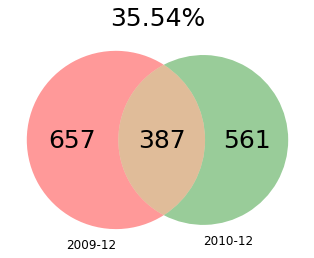

In [157]:
out = venn2([customer_0912, customer_1012], ('2009-12', '2010-12'))
for text in out.subset_labels:
    text.set_fontsize(25)
percentage = len(a&b)/len(a)*100
plt.title(f'{percentage:.02f}%', size = 25)
plt.savefig('/opt/ml/code/notebook/picture/2009-12comp2010-12.png', dpi=200)
plt.show()

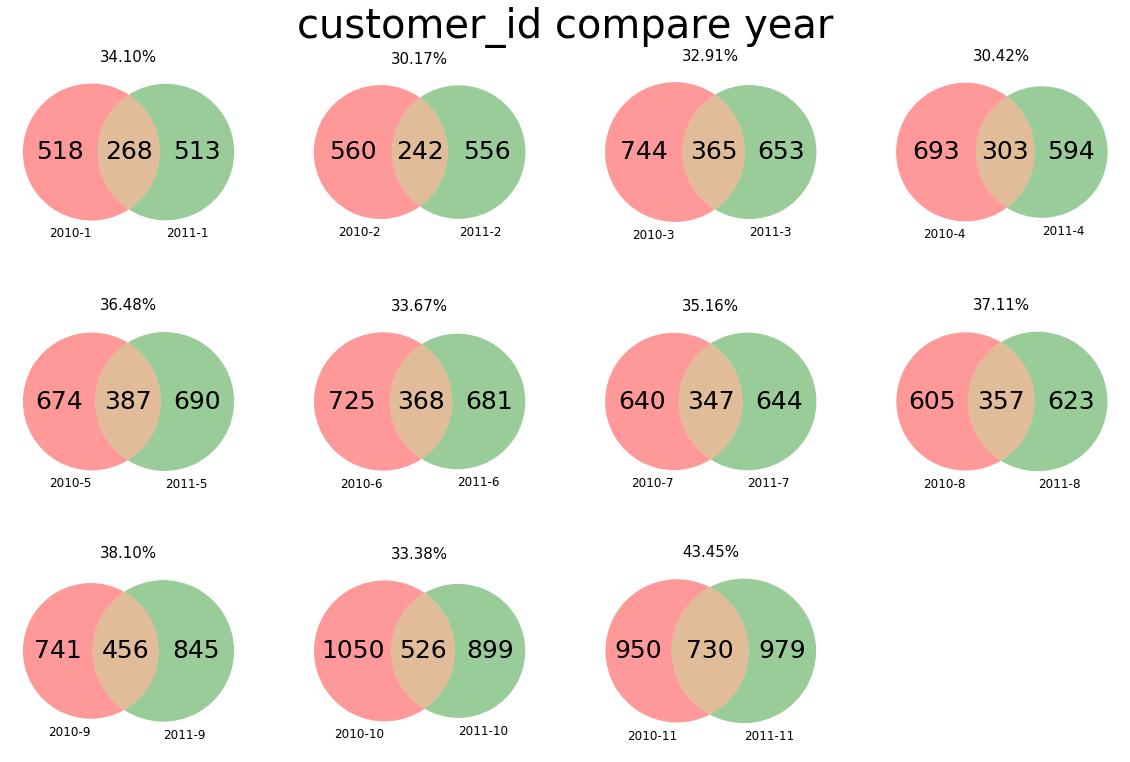

In [167]:
fig = plt.figure(figsize=(20, 13))
plt.title(f'customer_id compare year', size = 40)
plt.axis('off')
for i in range(1, 12):
    month_pre = merge_temp[merge_temp.standard == f'2010-{i:02d}']
    month_pre = month_pre[month_pre.total != 0].customer_id.unique()

    month_after = merge_temp[merge_temp.standard == f'2011-{i:02d}']
    month_after = month_after[month_after.total != 0].customer_id.unique()

    ax = fig.add_subplot(3,4,i)
    a = set(month_pre)
    b = set(month_after)
    percentage = len(a&b)/len(a)*100

    out = venn2([a, b], (f'2010-{i}', f'2011-{i}'))
    for text in out.subset_labels:
        text.set_fontsize(25)
    plt.title(f'{percentage:0.2f}%', size = 15)
plt.savefig('/opt/ml/code/notebook/picture/compare_year.png', dpi=200)
plt.show()

# 전후 달 비교

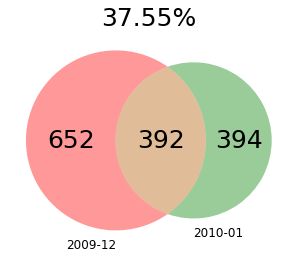

In [159]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total != 0].customer_id.unique()

month_1001 = merge_temp[merge_temp.standard == '2010-01']
month_1001 = month_1001[month_1001.total != 0].customer_id.unique()

a = set(month_0912)
b = set(month_1001)
out = venn2([a, b], ('2009-12', '2010-01'))
for text in out.subset_labels:
    text.set_fontsize(25)
    
percentage = len(a&b)/len(a)*100
plt.title(f'{percentage:.02f}%', size = 25)
plt.savefig('/opt/ml/code/notebook/picture/09_10compare_month.png', dpi=200)
plt.show()

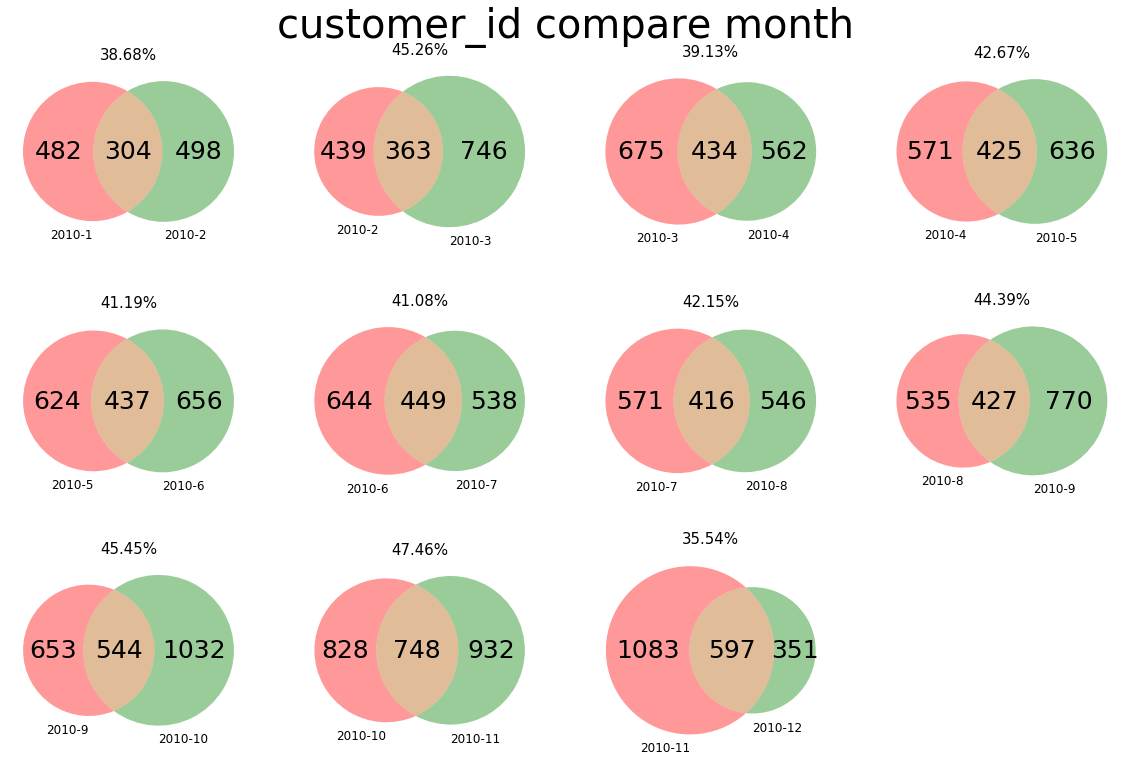

In [171]:
fig = plt.figure(figsize=(20, 13))
plt.title(f'customer_id compare month', size = 40)
plt.axis('off')
for i in range(1, 12):
    month_pre = merge_temp[merge_temp.standard == f'2010-{i:02d}']
    month_pre = month_pre[month_pre.total != 0].customer_id.unique()

    month_after = merge_temp[merge_temp.standard == f'2010-{i+1:02d}']
    month_after = month_after[month_after.total != 0].customer_id.unique()

    ax = fig.add_subplot(3,4,i)
    a = set(month_pre)
    b = set(month_after)
    percentage = len(a&b)/len(a)*100
    plt.title(f'{percentage:.02f}%', size = 15)

    out = venn2([a, b], (f'2010-{i}', f'2010-{i+1}'))
    for text in out.subset_labels:
        text.set_fontsize(25)
    plt.savefig('/opt/ml/code/notebook/picture/compare_month.png', dpi=200)
plt.show()

# 다른 해 유사 달 비교
## 모든 달 구매자가 있다?

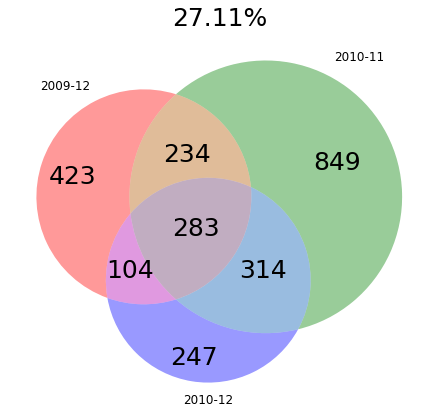

In [161]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total != 0].customer_id.unique()

month_1011 = merge_temp[merge_temp.standard == '2010-11']
month_1011 = month_1011[month_1011.total != 0].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total != 0].customer_id.unique()

customer_0912 = set(month_0912)
customer_1011 = set(month_1011)
customer_1012 = set(month_1012)

percentage = len(customer_0912&customer_1011&customer_1012)/len(customer_0912)*100


fig = plt.figure(figsize=(10, 7))

out = venn3([customer_0912, customer_1011, customer_1012], ('2009-12', '2010-11', '2010-12'))
for text in out.subset_labels:
    text.set_fontsize(25)
plt.title(f'{percentage:.02f}%', size=25)
plt.show()

# 

# 은근 매년, 달달이 구매한다

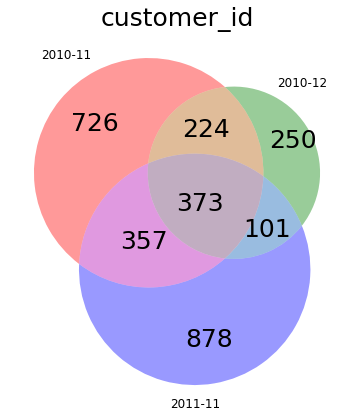

In [162]:
month_1111 = merge_temp[merge_temp.standard == '2011-11']
month_1111 = month_1111[month_1111.total != 0].customer_id.unique()

month_1011 = merge_temp[merge_temp.standard == '2010-11']
month_1011 = month_1011[month_1011.total != 0].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total != 0].customer_id.unique()

customer_1111 = set(month_1111)
customer_1011 = set(month_1011)
customer_1012 = set(month_1012)

# percentage = len(customer_0912&customer_1011&customer_1012)/len(a)*100
# plt.title(f'{percentage:.02f}%')

fig = plt.figure(figsize=(10, 7))

out = venn3([customer_1011, customer_1012, customer_1111], ('2010-11', '2010-12', '2011-11'))
for text in out.subset_labels:
    text.set_fontsize(25)
plt.title('customer_id', size = 25)
plt.show()

# '산다'라는게 중요하지만 결국은 300을 넘어야 한다
### 환불 또한 구매 횟수로 칠 것인가?

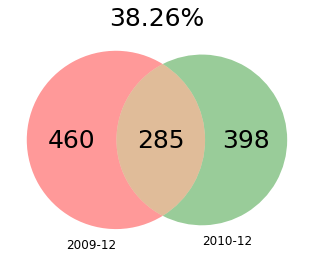

In [222]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total >= 300].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total >= 300].customer_id.unique()

a = set(month_0912)
b = set(month_1012)
out = venn2([a, b], ('2009-12', '2010-12'))
for text in out.subset_labels:
    text.set_fontsize(25)
    
percentage = len(a&b)/len(a)*100
plt.title(f'{percentage:.02f}%', size = 25)
plt.savefig('/opt/ml/code/notebook/picture/2009-12comp2010-12_300.png', dpi=200)
plt.show()

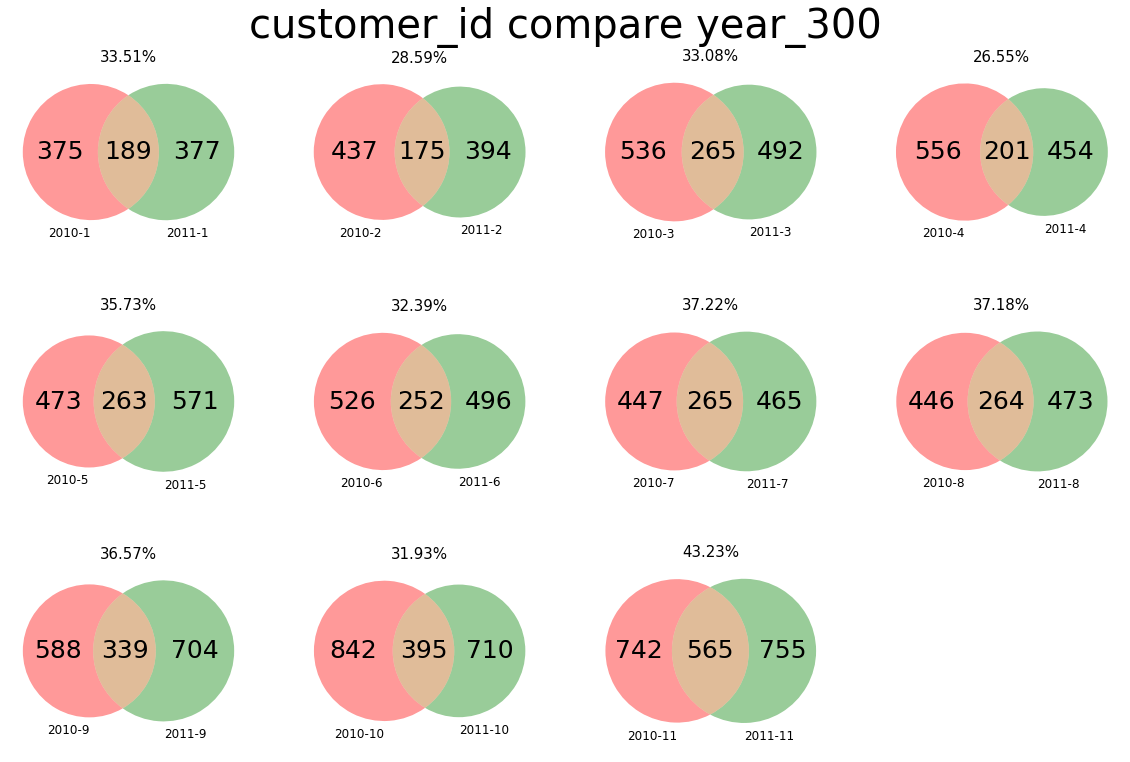

In [223]:
fig = plt.figure(figsize=(20, 13))
plt.title(f'customer_id compare year_300', size = 40)
plt.axis('off')
for i in range(1, 12):
    month_pre = merge_temp[merge_temp.standard == f'2010-{i:02d}']
    month_pre = month_pre[month_pre.total >= 300].customer_id.unique()

    month_after = merge_temp[merge_temp.standard == f'2011-{i:02d}']
    month_after = month_after[month_after.total >= 300].customer_id.unique()

    ax = fig.add_subplot(3,4,i)
    a = set(month_pre)
    b = set(month_after)
    percentage = len(a&b)/len(a)*100

    out = venn2([a, b], (f'2010-{i}', f'2011-{i}'))
    for text in out.subset_labels:
        text.set_fontsize(25)
    plt.title(f'{percentage:0.2f}%', size = 15)
plt.savefig('/opt/ml/code/notebook/picture/compare_year_300.png', dpi=200)
plt.show()

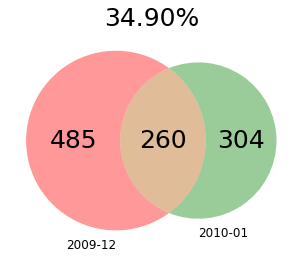

In [224]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total >= 300].customer_id.unique()

month_1001 = merge_temp[merge_temp.standard == '2010-01']
month_1001 = month_1001[month_1001.total >= 300].customer_id.unique()

a = set(month_0912)
b = set(month_1001)
out = venn2([a, b], ('2009-12', '2010-01'))
for text in out.subset_labels:
    text.set_fontsize(25)
    
percentage = len(a&b)/len(a)*100
plt.title(f'{percentage:.02f}%', size = 25)
plt.savefig('/opt/ml/code/notebook/picture/09_10compare_month_300.png', dpi=200)
plt.show()

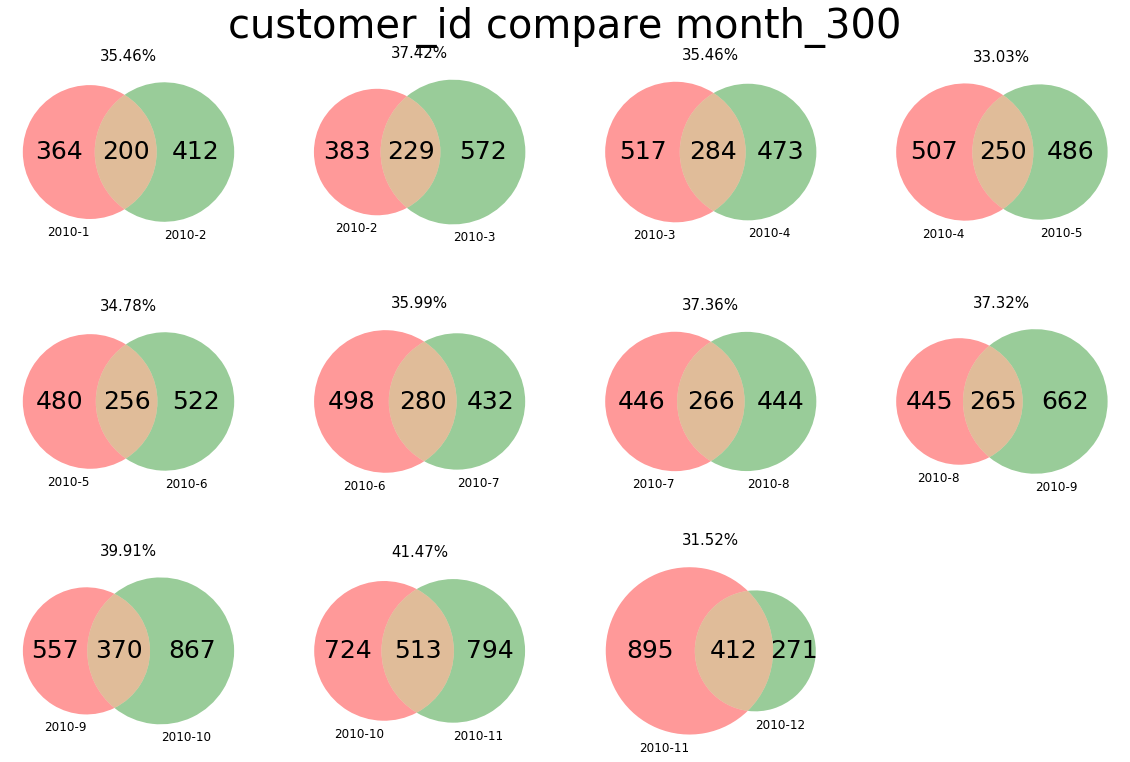

In [225]:
fig = plt.figure(figsize=(20, 13))
plt.title(f'customer_id compare month_300', size = 40)
plt.axis('off')
for i in range(1, 12):
    month_pre = merge_temp[merge_temp.standard == f'2010-{i:02d}']
    month_pre = month_pre[month_pre.total >= 300].customer_id.unique()

    month_after = merge_temp[merge_temp.standard == f'2010-{i+1:02d}']
    month_after = month_after[month_after.total >= 300].customer_id.unique()

    ax = fig.add_subplot(3,4,i)
    a = set(month_pre)
    b = set(month_after)
    percentage = len(a&b)/len(a)*100
    plt.title(f'{percentage:.02f}%', size = 15)

    out = venn2([a, b], (f'2010-{i}', f'2010-{i+1}'))
    for text in out.subset_labels:
        text.set_fontsize(25)
    plt.savefig('/opt/ml/code/notebook/picture/compare_month_300.png', dpi=200)
plt.show()

# 중복 구매자의 퍼센티지가 크게 변하지 않는다

2009-12:745, 2010-11:1307, 2010-12:683


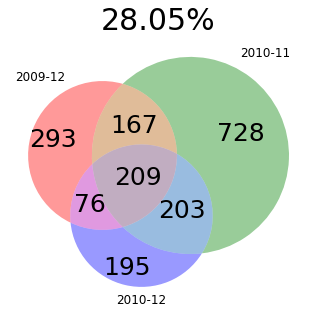

In [226]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total >= 300].customer_id.unique()

month_1011 = merge_temp[merge_temp.standard == '2010-11']
month_1011 = month_1011[month_1011.total >= 300].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total >= 300].customer_id.unique()

customer_0912 = set(month_0912)
customer_1011 = set(month_1011)
customer_1012 = set(month_1012)

print(f'2009-12:{len(customer_0912)}, 2010-11:{len(customer_1011)}, 2010-12:{len(customer_1012)}')

percentage = len(customer_0912&customer_1011&customer_1012)/len(customer_0912)*100


fig = plt.figure(figsize=(7, 5))

out = venn3([customer_0912, customer_1011, customer_1012], ('2009-12', '2010-11', '2010-12'))
for text in out.subset_labels:
    text.set_fontsize(25)
plt.title(f'{percentage:.02f}%', size=30)
plt.show()

# 위의 중심에 있는 사람들은 무엇을 사는 것인가?

In [227]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total >= 300].customer_id.unique()

month_1011 = merge_temp[merge_temp.standard == '2010-11']
month_1011 = month_1011[month_1011.total >= 300].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total >= 300].customer_id.unique()

customer_0912 = set(month_0912)
customer_1011 = set(month_1011)
customer_1012 = set(month_1012)

vip = customer_0912 | customer_1011 | customer_1012

In [228]:
buys = train[train.customer_id.isin(vip)].description.unique()

In [229]:
len(buys)

5215

### 상품 전체 가짓수가 총 5297가지 인데 2009.12월, 2010.11월, 2010.12월에 4843가지의 상품을 샀다..?
### -> 역시 VIP...

### 합집합의 결과는 5215가지..!

# 12월에만 사는 상품이 궁금해졌다
- 09년 12월: 5093개 
- 10년 11월: 5127개 
- 10년 12월: 5029개
### 09년 12월과 10년 12월의 교집합은 4917가지 합집합은 5157이다.

In [13]:
month_0912 = merge_temp[merge_temp.standard == '2009-12']
month_0912 = month_0912[month_0912.total >= 300].customer_id.unique()

month_1001 = merge_temp[merge_temp.standard == '2010-01']
month_1001 = month_1001[month_1001.total >= 300].customer_id.unique()

month_1011 = merge_temp[merge_temp.standard == '2010-11']
month_1011 = month_1011[month_1011.total >= 300].customer_id.unique()

month_1012 = merge_temp[merge_temp.standard == '2010-12']
month_1012 = month_1012[month_1012.total >= 300].customer_id.unique()

month_1101 = merge_temp[merge_temp.standard == '2011-01']
month_1101 = month_1101[month_1101.total >= 300].customer_id.unique()

month_1111 = merge_temp[merge_temp.standard == '2011-11']
month_1111 = month_1111[month_1111.total >= 300].customer_id.unique()

customer_0912 = set(month_0912)
customer_1001 = set(month_1001)
customer_1011 = set(month_1011)
customer_1012 = set(month_1012)
customer_1101 = set(month_1101)
customer_1111 = set(month_1111)

vip_12 = customer_0912 - customer_1011
len(vip_12)

369

In [18]:
buys_12 = train[train.customer_id.isin(vip_12)].description.unique()
len(buys_12)

4416

### 상품의 09년도 12월과 10년 11월의 차집합은 10년 11월과 10년 12월의 차집합과 얼마나 겹칠까?
### -> 26가지

In [19]:
buys_0912 = set(train[train.customer_id.isin(customer_0912)].description.unique())
buys_1011 = set(train[train.customer_id.isin(customer_1011)].description.unique())
buys_1012 = set(train[train.customer_id.isin(customer_1012)].description.unique())

In [20]:
print(len(buys_0912-buys_1011))
print(len(buys_1012-buys_1011))
print(len((buys_0912-buys_1011) & (buys_1012-buys_1011)))
only_12 = (buys_0912-buys_1011) & (buys_1012-buys_1011)

69
45
26


In [21]:
only_12

{'AMBER CRYSTAL DROP EARRINGS',
 'BAROQUE BUTTERFLY EARRINGS MONTANA',
 'BLUE DROP EARRINGS W BEAD CLUSTER',
 'BLUE HIBISCUS  HAIR CLIP',
 'BREAD BIN, DINER STYLE, MINT',
 'CHOCOLATE ICE CREAM CANDLE',
 'CLASSICAL ROSE TABLE LAMP',
 'CRYSTAL SMALL JEWELLED PHOTOFRAME',
 'ENGLISH ROSE SET/3 GARDEN TOOLS',
 'GIANT SEVENTEEN DRAWER SIDEBOARD',
 'GLASS BELL JAR LARGE',
 'GLASS BELL JAR SMALL',
 'GOLD JEWELERY BOX',
 'GOLD M.O.P ORBIT BRACELET',
 'GREEN DROP EARRINGS W BEAD CLUSTER',
 'JADE GREEN PAIR ENAMEL HAIR SLIDES',
 'LARGE GLASS HEART TRINKET POT',
 'MODERN CHRISTMAS TREE CANDLE',
 'MODERN CHRISTMAS TREE CANDLE ',
 'PAPER LANTERN 5 POINT STUDDED STAR',
 'PINK STRIPES SHOULDER BAG',
 'RUBY GLASS CLUSTER EARRINGS',
 'S/16 BLACK SHINY/MAT BAUBLES',
 'S/3 ROSE GARDEN SCENT SQU CANDLE',
 'SET/2 TEA TOWELS MODERN VINTAGE',
 'WHITE VINTAGE CRYSTAL BRACELET'}

# 1월까지 늘려보자 + 11년도 11월
### 코드가 점점...
### -> 늘렸으나 26가지로 동일!

In [22]:
buys_0912 = set(train[train.customer_id.isin(customer_0912)].description.unique())
buys_1001 = set(train[train.customer_id.isin(customer_1001)].description.unique())
buys_1011 = set(train[train.customer_id.isin(customer_1011)].description.unique())
buys_1012 = set(train[train.customer_id.isin(customer_1012)].description.unique())
buys_1101 = set(train[train.customer_id.isin(customer_1101)].description.unique())
buys_1111 = set(train[train.customer_id.isin(customer_1111)].description.unique())

### 전체 상품은 총 5297가지

In [23]:
print(len(buys_0912))
print(len(buys_1001))
print(len(buys_1011))
print(len(buys_1012))
print(len(buys_1101))
print(len(buys_1111))

5093
4998
5127
5029
4977
5097


In [24]:
only_12 = (buys_0912 | buys_1012) - (buys_1001 | buys_1011 | buys_1101 | buys_1111)
print(len(only_12))
only_12

26


{' SET Of 6 SOLDIER SKITTLES',
 'ANTIQUE RASPBERRY FLOWER EARRINGS',
 'BREAD BIN, DINER STYLE, MINT',
 'BROWN COZY SQUARE PHOTO ALBUM',
 'CRACKED GLAZE NECKLACE BROWN',
 'CRYSTAL SMALL JEWELLED PHOTOFRAME',
 'F FAIRY POTPOURRI CUSHIONS SUMMER',
 'F.FAIRY,CANDLE IN GLASS,LAVENDER',
 'FIRE POLISHED GLASS BRACELET RED',
 'FOLDING SHIRT TIDY',
 'FROSTED GLASS WITH SILVER SURROUND',
 'GLASS AND PAINTED BEADS BRACELET OL',
 'GLASS BELL JAR LARGE',
 'GLASS BELL JAR SMALL',
 'OCCASIONS GIFT CARD ASSORTMENT',
 'ORANGE CANDLE',
 'PINK BEADED CONE CHRISTMAS',
 'PINK BUTTERFLY C/COVER ',
 'PINK STRIPES SHOULDER BAG',
 'PINK SWEETIE NECKLACE',
 'ROSE SCENTED VOTIVE CANDLE',
 'SET OF 36 DOILIES VINTAGE CHRISTMAS',
 'SET/2 TEA TOWELS MODERN VINTAGE',
 'SILVER WINE GOBLET',
 'VANILLA SCENTED VOTIVE CANDLE',
 'WRAP SPEED DEMONS '}

In [25]:
train[train.description.isin(only_12)].head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
1174,489560,16161C,WRAP SPEED DEMONS,100,2009-12-01 12:56:00,0.1650,13526,United Kingdom,16.5000
1204,489561,35051B,PINK BEADED CONE CHRISTMAS,6,2009-12-01 12:57:00,0.6930,14654,United Kingdom,4.1580
3611,489822,72754D,F FAIRY POTPOURRI CUSHIONS SUMMER,1,2009-12-02 13:26:00,2.7885,14204,United Kingdom,2.7885
8459,490312,85024A,CRYSTAL SMALL JEWELLED PHOTOFRAME,1,2009-12-04 15:16:00,2.7225,17961,United Kingdom,2.7225
8800,490360,72752B,"F.FAIRY,CANDLE IN GLASS,LAVENDER",1,2009-12-04 16:52:00,7.0125,13679,United Kingdom,7.0125


# 왜 구했더라?
### idea: 교집합을 구해서 그 상품을 샀는지 안샀는지로 구분!
### 가설: 11월에 안샀다면 12월에 사겠지?!
### 11월에 샀다면 12월에 샀는가?!
### 11월에 안샀다면 12월에 샀는가!?

In [26]:
season = (buys_0912 & buys_1012 & buys_1001 & buys_1011 & buys_1101 & buys_1111)

In [27]:
len(season)

4787

In [55]:
only_0912 = (customer_0912 - customer_1001)
only_1001 = (customer_1001 - customer_0912)

only_0912 = train[train.customer_id.isin(only_0912)]
only_0912 = only_0912[only_0912.order_date < '2010']
only_1001 = train[train.customer_id.isin(only_1001)]
only_1001 = only_1001[only_1001.order_date < '2010-02-01']
only_1001 = only_1001[only_1001.order_date > '2009-12-31 23:59:59']

pre_0912 = set(only_0912.description.unique())
after_1001 = set(only_1001.description.unique())

# customer_1011 - customer_1012
# customer_1012 - customer_1101

In [56]:
inter = pre_0912 & after_1001

In [57]:
print(len(inter))

1569


In [58]:
only_1011 = (customer_1011 - customer_1012)
only_1012 = (customer_1012 - customer_1011)

only_1011 = train[train.customer_id.isin(only_1011)]
only_1011 = only_1011[only_1011.order_date < '2010-12-01']
only_1011 = only_1011[only_1011.order_date > '2010-10-31 23:59:59']

only_1012 = train[train.customer_id.isin(only_1012)]
only_1012 = only_1012[only_1012.order_date < '2011-01-01']
only_1012 = only_1012[only_1012.order_date > '2010-11-30 23:59:59']

pre_1011 = set(only_1011.description.unique())
after_1012 = set(only_1012.description.unique())

In [59]:
inter2 = pre_1011 & after_1012
print(len(inter2))

1734


In [60]:
print(len(inter&inter2))

752
